# Peeking Simulator

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm

# A/A Test Peeking

In [2]:
def pooled_standard_error(s1, s2, n1, n2):
    """
    Calculate the pooled standard error for comparing two means.
    
    Parameters:
    s1 (float): Standard deviation of the control group.
    s2 (float): Standard deviation of the experimental group.
    n1 (int): Sample size of the control group.
    n2 (int): Sample size of the experimental group.
    
    Returns:
    float: Pooled standard error.
    """
    pooled_se = np.sqrt(((s1**2) / n1) + ((s2**2) / n2))
    return pooled_se


def z_to_p_value(z_score, two_tailed=True):
    """
    Calculate the p-value from a z-score.
    """

    if two_tailed:
        # Two-tailed p-value
        p_value = 2 * (1 - norm.cdf(abs(z_score)))
    else:
        # One-tailed p-value
        p_value = 1 - norm.cdf(z_score) if z_score > 0 else norm.cdf(z_score)
    
    return p_value

In [298]:
effect_size = 0.03516
alpha = 0.05 # significance level, false positive probability
power = 0.8 # probability of correctly rejecting the null hypothesis

In [299]:
power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='larger')
print(f"Sample size per group: {sample_size:.0f}")

Sample size per group: 10003


In [300]:
point_estimate_lst = []
sample_lst = []
confidence_level_lst = []
p_value_lst = []

for n in range(3,round(sample_size)+3, 1000):

    control = np.random.standard_normal(size=n)
    treatment = np.random.standard_normal(size=n) 
    point_estimate = (control - treatment).mean()
    
    pooled_se = pooled_standard_error(s1=control.std(), s2=treatment.std(), n1=n, n2=n)
    z = point_estimate / pooled_se
    p_value = z_to_p_value(z, two_tailed=False)

    confidence_level_lst.append(1 - p_value)
    p_value_lst.append(p_value)
    point_estimate_lst.append(point_estimate)
    sample_lst.append(n)


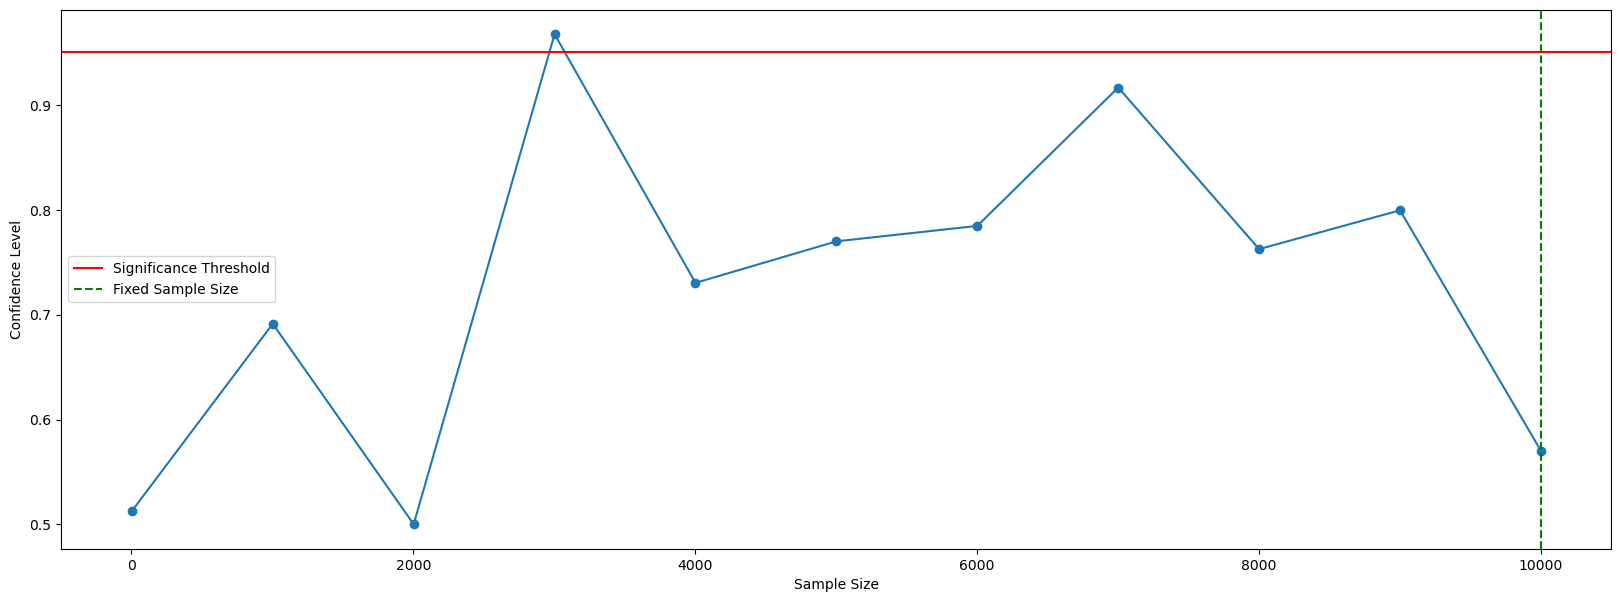

In [301]:
plt.figure(figsize=(20,7))
plt.plot(sample_lst,confidence_level_lst, marker='o')
plt.axhline(1-alpha, c='red', label='Significance Threshold')
plt.axvline(round(sample_size), c='green', label='Fixed Sample Size', ls='--')
plt.ylabel("Confidence Level")
plt.xlabel("Sample Size")
plt.legend()
plt.show()

### Single A/A Test. How is the Type 1 error inflated?


- In **Fixed Size Sample Testing**, you commit to how many observations you will collect (green dashed line) before evaluating your experiment. If you stop your experiment before the required sample size, you're peeking and therefore inflating your Type 1 error probability.

- The validity of the statement that you have a 5% False Positive probability as indicated by alpha comes from the fact that run the experiment all the way until the green dashed line. For example, If you were to run 100 A/A tests where you allow it to run all the way to the green dashed line, on average 5 of those will detect a difference, which is being above the red line (Type 1 error).

### Suppose significance is declared is less than a cutoff alpha. Then:

In [309]:

def aa_test_simulation(sample_size):
    aa_tests = []
    peeking_lst = []

    for _ in range(1000): # running 100 A/A Tests

        point_estimate_lst = []
        sample_lst = []
        confidence_level_lst = []
        p_value_lst = []

        for n in range(3,round(sample_size)+3, int(np.floor(60002 / 10))):

            control = np.random.standard_normal(size=n)
            treatment = np.random.standard_normal(size=n) 
            point_estimate = (control - treatment).mean()
            
            pooled_se = pooled_standard_error(s1=control.std(), s2=treatment.std(), n1=n, n2=n)
            z = point_estimate / pooled_se
            p_value = z_to_p_value(z, two_tailed=False)

            confidence_level_lst.append(1 - p_value)
            p_value_lst.append(p_value)
            point_estimate_lst.append(point_estimate)
            sample_lst.append(n)

        peeking_lst.append( any([1 if i < alpha else 0 for i in p_value_lst]) )
        aa_tests.append(p_value_lst[-1]<alpha)

    return sum(peeking_lst)/100, sum(aa_tests)/100

    

In [310]:
sample_size=[i for i in range(2,61000+2, 3000)]
peeking_lst = []
aa_test_lst = []

for sample in sample_size:
    peeking, aa_test = aa_test_simulation(sample_size=sample)
    peeking_lst.append(peeking)
    aa_test_lst.append(aa_test)


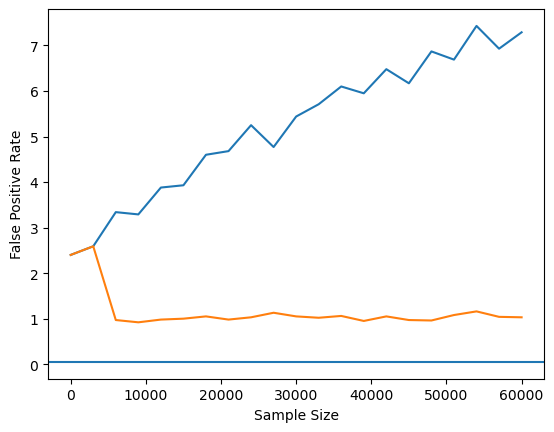

In [311]:
plt.plot(sample_size,peeking_lst)
plt.plot(sample_size,aa_test_lst)
plt.ylabel("False Positive Rate")
plt.xlabel("Sample Size")
plt.axhline(alpha, label='Prestablished Alpha')
plt.show()


# Sequential Testing

In [120]:
n_lst = []
mean_lst = []
std_error_lst = []
std_error_log_lst = []

for n in range(10,10000, 1):
    mean  = np.random.standard_normal(size=n).mean()
    n_lst.append(n)
    mean_lst.append(mean)
    std_error_lst.append(1/np.sqrt(n))
    std_error_log_lst.append(np.sqrt(np.log(n)/n))

Text(0, 0.5, 'Sample Mean')

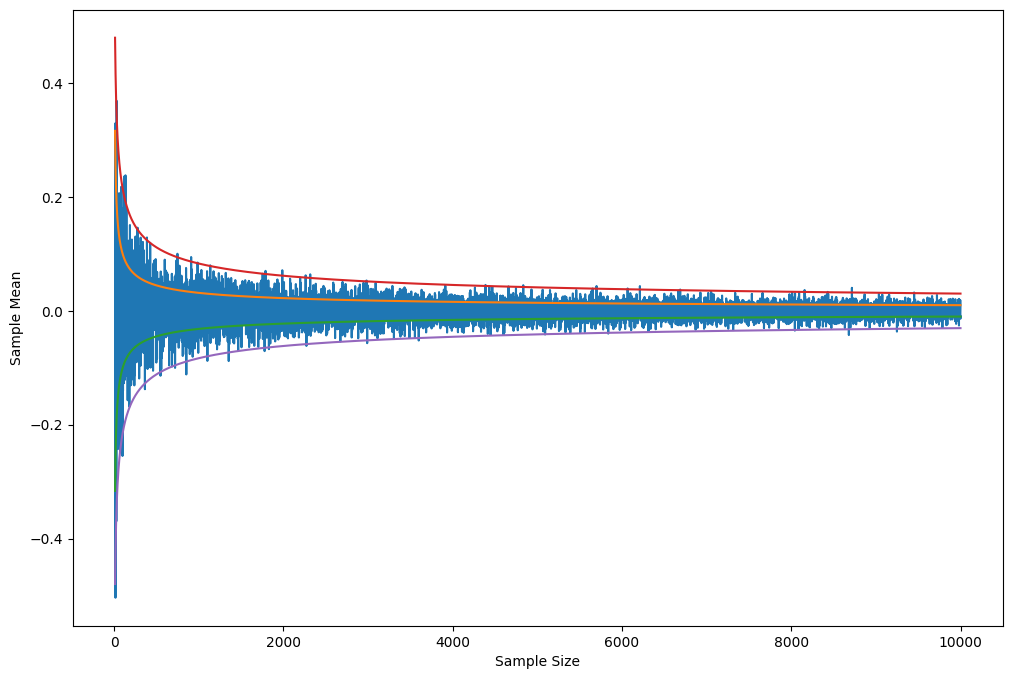

In [121]:
plt.figure(figsize=(12,8))
plt.plot(n_lst, mean_lst)
plt.plot(n_lst, std_error_lst)
plt.plot(n_lst, [-1*i for i in std_error_lst])

plt.plot(n_lst, std_error_log_lst)
plt.plot(n_lst, [-1*i for i in std_error_log_lst])
plt.xlabel("Sample Size")
plt.ylabel("Sample Mean")